In [2]:
from causalsim import *
import metrics
from econml.metalearners import XLearner
from econml.dr import DRLearner
from econml.dml import CausalForestDML
from econml.metalearners import TLearner
from econml.metalearners import SLearner
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Data Generation 
#### Simple model: Treatment effect for individual i: \tau_i = \beta * x_{i1} 

In [3]:
n = 1000  # Number of individuals
p = 1     # Number of covariates
beta = 1  # Beta_1 value for treatment effect
sigma = 1 # Sigma value for noise term
data = simulation_simple(n = n, p = p, beta = beta, sigma = sigma)
print(data.head(10))

         X1       tau  Z   epsilon         Y
0  0.430586  0.430586  1  0.462752  0.893338
1  0.037433  0.037433  1  0.664903  0.702336
2 -0.432555 -0.432555  0 -0.037979 -0.037979
3 -1.090642 -1.090642  0  0.615598  0.615598
4  0.653135  0.653135  0  0.868013  0.868013
5 -1.419457 -1.419457  1  1.297772 -0.121684
6 -2.011673 -2.011673  0 -1.333535 -1.333535
7  0.304025  0.304025  1 -0.000883  0.303142
8 -1.901210 -1.901210  1  0.884042 -1.017168
9  0.002087  0.002087  0  1.687040  1.687040


In [4]:
data = simulation_XLearner_1(100000, 20)
data[data['Z'] == 1]

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,tau,Z,epsilon,Y
9,-0.496088,-0.022766,0.070395,0.568984,-1.273381,0.789586,1.674101,-2.143463,-1.120339,0.320016,...,1.147562,-0.108353,1.732981,0.759770,0.095565,1.384467,0,1,-1.641734,-41.761279
34,1.428249,0.111888,-1.872457,0.335519,-0.601716,-0.136839,-0.297459,-0.001404,0.913241,-0.604531,...,2.176798,0.222213,0.439354,-0.741435,0.151807,0.078273,8,1,0.233723,16.718593
54,-0.296839,1.376749,-1.368360,0.719972,0.356114,-0.970081,-1.182227,-0.712525,1.141253,0.492262,...,-0.091870,-0.421431,-0.280111,-0.061651,0.993126,-0.707533,8,1,0.941153,23.906504
68,1.308216,0.314400,0.200765,0.932224,0.804101,-0.004734,0.034687,-0.576285,-0.185456,0.789252,...,-0.219679,-1.367686,0.623967,-1.080166,0.529251,-0.864805,8,1,1.362545,16.342097
78,-0.495750,0.668980,-1.559468,-1.939434,-0.257589,-2.101591,1.849060,0.391213,1.721842,-0.956719,...,-1.214125,-0.857637,0.601066,-0.990983,1.357827,0.162467,8,1,-0.780623,10.024649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99661,0.047342,1.664562,-0.303854,1.108347,-0.347439,-0.546837,-0.216583,-0.908900,-0.488691,0.484791,...,0.173938,-0.420381,0.809682,0.088223,0.112140,0.165189,8,1,1.346979,6.906960
99718,1.837694,0.765136,0.697709,-0.729011,-0.482960,-1.852329,0.285359,-0.241659,0.120036,1.042296,...,-0.640699,-0.523410,0.432556,1.615792,-1.061639,0.388801,8,1,1.117892,18.205613
99851,0.400210,-1.046333,0.646454,-0.493653,0.208957,1.641294,1.205927,1.757995,-0.313510,-1.310838,...,-0.511958,-0.374563,1.187983,-0.639020,1.606121,-0.055471,0,1,1.877053,-18.672353
99868,-1.000342,0.204487,0.055637,-0.703286,-2.818273,-0.173047,-0.250766,-0.512305,0.804282,-1.168389,...,-0.631479,0.690200,-0.202953,0.391542,1.899776,1.613736,8,1,0.890335,-4.408018


In [30]:
data = simulation_XLearner_2(10000, 20)
data[data['Z'] == 1]

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,tau,Z,epsilon,Y
6,-0.703022,1.089938,2.156367,0.668944,-1.508593,-1.856937,0.435492,-0.230478,-0.637049,0.206781,...,0.354779,0.670145,-0.260592,-0.983146,-0.638208,0.378727,2.148336e-06,1,-0.454249,-0.454248
8,0.496333,-1.074361,1.626653,-0.299335,-1.536646,-0.195831,1.933327,0.308801,-0.540054,-1.700410,...,-0.257795,-0.561495,-0.938673,-0.960344,0.098184,-0.962796,1.220492e-08,1,-0.903217,-0.903217
11,-0.715659,0.028207,-0.195612,-0.464552,-0.345674,1.267021,-1.214293,0.404086,-0.266571,-0.741379,...,0.037727,-0.612168,0.060121,0.869845,0.318623,1.621213,6.402299e-09,1,0.033296,0.033296
15,0.515988,-0.478844,0.567257,-1.516586,-2.359308,2.198595,-0.361978,1.244034,-0.185703,-0.488451,...,0.706442,-1.440325,-0.819893,0.352955,-0.271351,-0.815239,1.735451e-05,1,0.013633,0.013641
17,1.931700,0.174432,-0.113659,-0.596871,0.418846,-1.072973,2.124940,1.000671,1.144294,-0.845884,...,-1.083034,-0.688784,-0.410481,0.446334,-0.795505,-0.607341,7.883254e-02,1,0.464578,0.503995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9990,0.026824,1.423759,-1.548697,-0.097663,-0.112097,-1.478511,-0.230940,-0.787400,0.276241,-0.769155,...,-0.191283,-1.486380,1.457011,0.963521,-0.210858,0.880457,1.363323e-02,1,0.826070,0.832887
9991,-0.536614,-0.845806,0.449298,0.787247,-1.577452,-1.102446,-0.024563,-1.557966,-0.432610,-1.161707,...,-0.292983,0.620450,-1.417935,0.077656,-0.983599,-0.863880,1.534594e-12,1,0.160658,0.160658
9993,-0.205014,1.401577,-0.658414,0.652294,-0.682587,-0.099711,-1.281646,2.361778,-0.378393,-0.445262,...,0.022554,0.824138,0.560546,-0.667064,0.819558,-0.731969,8.467542e-04,1,-1.618565,-1.618141
9996,-0.360293,-0.915610,0.303806,0.764824,1.053256,1.429466,-1.899217,-0.102563,0.965897,-1.637649,...,0.378372,-0.502325,0.996080,1.182630,-0.289473,0.424466,5.509318e-12,1,0.465043,0.465043


#### Categorical Model

In [3]:
n = 1000  # Number of individuals
p = 1     # Number of covariates
beta = 1  # Beta_1 value for treatment effect
sigma = 1 # Sigma value for noise term
data_cat = simulation_categorical(n = n, p = p, beta = beta, sigma = sigma)
print(data_cat.head(10))

         X1  tau  Z   epsilon         Y
0  1.023143    1  1  0.056511  1.056511
1 -0.299046    0  0 -1.296546 -1.296546
2 -0.556704    0  1  0.245307  0.245307
3 -1.052029    0  1  0.940470  0.940470
4 -0.326775    0  0 -0.107064 -0.107064
5 -1.649053    0  1  0.280066  0.280066
6  0.300468    1  0  1.277158  1.277158
7 -0.728725    0  0 -1.486377 -1.486377
8  0.510106    1  0 -0.995065 -0.995065
9 -0.542140    0  0 -0.575164 -0.575164


#### Assigning variables for econml metalearner functions

In [31]:
X = data[[col for col in data.columns if col.startswith('X')]]
T = data['Z'] #treatment indicator
y = data['Y']
tau = np.array(data['tau'])

## Linear Regression

#### y ~ X + Z + X*Z

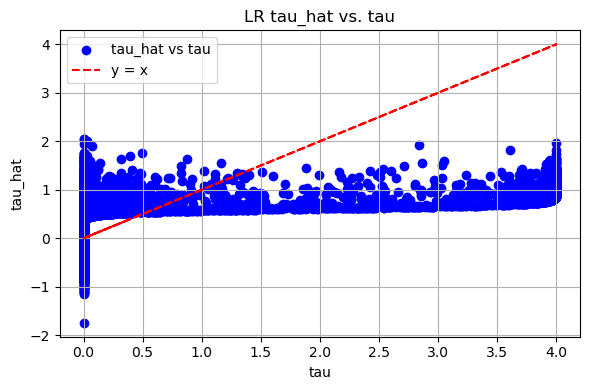

In [7]:
data_lr = data.copy()
data_lr['X1*Z'] = data_lr['X1'] * data_lr['Z'] #Setting interaction term
lr_xfit = data_lr[['X1', 'Z', 'X1*Z']]

lr = LinearRegression() #Fit linear regression
lr.fit(lr_xfit, data_lr['Y'])

bz = lr.coef_[1]
bzx = lr.coef_[2]

tau_hat_lr = bz + bzx*data['X1']


mse_lr, bias_lr, r2_lr = metrics.evaluate(tau, tau_hat_lr)

metrics.tau_plot(tau, tau_hat_lr, 'LR tau_hat vs. tau')

In [8]:
print(f'LR metrics:\nMse: {mse_lr}\nBias: {bias_lr}\nR2 {r2_lr}')

LR metrics:
Mse: 0.9283103553178811
Bias: -0.0017415953679959322
R2 0.1632250556446917


## X-Learner

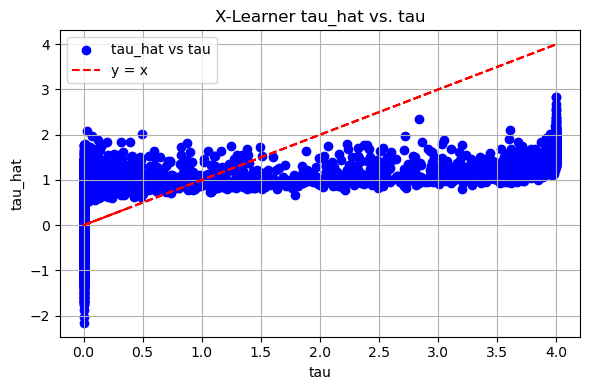

In [9]:
est = XLearner(models=LinearRegression())
est.fit(y, T, X=X)
tau_hat_x = est.effect(X)
mse_x, bias_x, r2_x = metrics.evaluate(tau, tau_hat_x)
metrics.tau_plot(tau, tau_hat_x, 'X-Learner tau_hat vs. tau')

In [10]:
print(f'X-learner metrics:\nMse: {mse_x}\nBias: {bias_x}\nR2 {r2_x}')

X-learner metrics:
Mse: 0.7491529903127837
Bias: -0.00016238825057756116
R2 0.3247167305723606


## S + T Learner

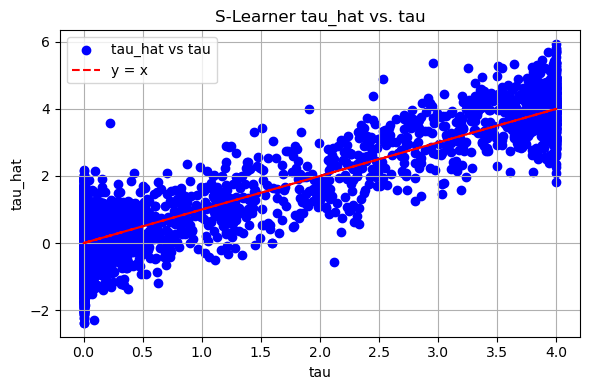

In [11]:
est = SLearner(overall_model=RandomForestRegressor())
est.fit(y, T, X=X)
tau_hat_s = est.effect(X)

mse_s, bias_s, r2_s = metrics.evaluate(tau, tau_hat_s)
metrics.tau_plot(tau, tau_hat_s, 'S-Learner tau_hat vs. tau')

In [19]:
print(f'S-learner metrics:\nMse: {mse_s}\nBias: {bias_s}\nR2 {r2_s}')

S-learner metrics:
Mse: 0.4351414858689018
Bias: -0.0019287667724128934
R2 0.6077653442743807


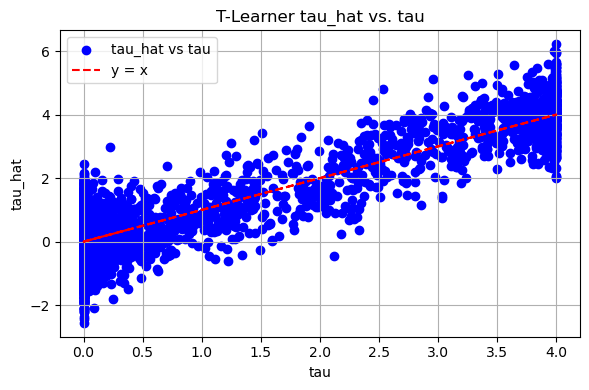

In [27]:
#est = TLearner(models=RandomForestRegressor())
#est.fit(y, T, X=X)
#tau_hat_t = est.effect(X)
tau_hat_t = Causal_TLearner(data, RandomForestRegressor())
mse_t, bias_t, r2_t = metrics.evaluate(tau, tau_hat_t)
metrics.tau_plot(tau, tau_hat_t, 'T-Learner tau_hat vs. tau')

In [29]:
print(f'T-learner metrics:\nMse: {mse_t}\nBias: {bias_t}\nR2 {r2_t}')

T-learner metrics:
Mse: 0.43242391876041203
Bias: 0.000585639061219667
R2 0.6102149475271739


## DR-Learner

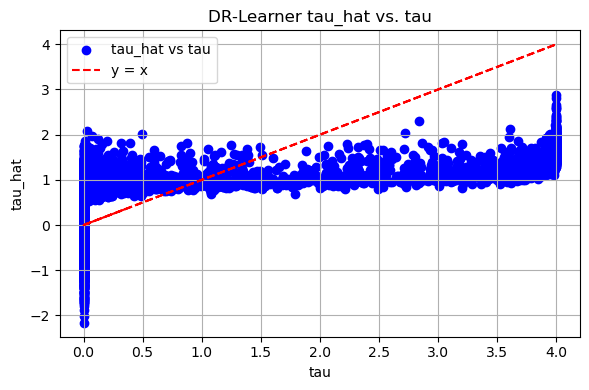

In [15]:
est = DRLearner()
est.fit(y, T, X=X, W=None)
tau_hat_dr = est.effect(X)

mse_dr, bias_dr, r2_dr = metrics.evaluate(tau, tau_hat_dr)
metrics.tau_plot(tau, tau_hat_dr, 'DR-Learner tau_hat vs. tau')

In [16]:
print(f'DR-learner metrics:\nMse: {mse_dr}\nBias: {bias_dr}\nR2 {r2_dr}')

DR-learner metrics:
Mse: 0.7489809065648966
Bias: 5.50437104629097e-05
R2 0.32487184611937336


## Causal Forest

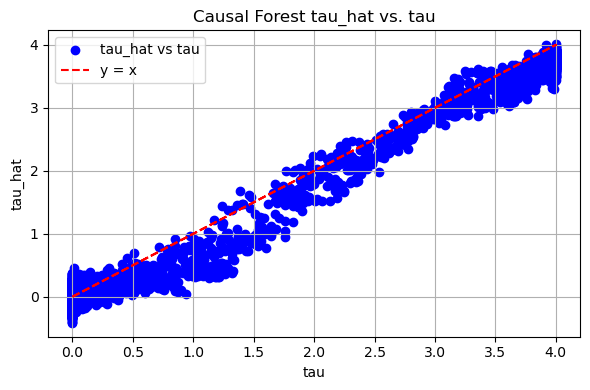

In [32]:
est = CausalForestDML(discrete_treatment=True)
est.fit(y, T, X=X, W=None)
tau_hat_cf = est.effect(X)

mse_cf, bias_cf, r2_cf = metrics.evaluate(tau, tau_hat_cf)
metrics.tau_plot(tau, tau_hat_cf, 'Causal Forest tau_hat vs. tau')

In [33]:
print(f'Causal Forest metrics:\nMse: {mse_cf}\nBias: {bias_cf}\nR2 {r2_cf}')

Causal Forest metrics:
Mse: 0.024863955548952404
Bias: 0.04439106423538852
R2 0.9784332303335951
